In [ ]:
# Importing Libraries
import os
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import timedelta

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 1: Downloading the Dataset from Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d emmarex/plantdisease
!unzip plantdisease.zip -d PlantVillage



Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: PlantVillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: PlantVillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: PlantVillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: PlantVillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: PlantVillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: PlantVillage

In [ ]:
# Step 2: Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading Dataset
data_dir = "PlantVillage/PlantVillage"
dataset = ImageFolder(root=data_dir, transform=transform)

# Splitting Dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Step 3: Twins-SVT Model Definition
class TwinsSVT(nn.Module):
    def __init__(self, num_classes):
        super(TwinsSVT, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize the model
num_classes = len(dataset.classes)
model = TwinsSVT(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Timer for training
start_time = time.time()

In [ ]:
# Training Loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    # Validation Loop
    model.eval()
    val_loss, val_corrects = 0.0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Training Time
end_time = time.time()
training_time = timedelta(seconds=int(end_time - start_time))
print(f"\nTraining complete in: {training_time}")

Epoch 1/10, Train Loss: 1.7370, Train Acc: 0.5230, Val Loss: 0.8791, Val Acc: 0.7049
Epoch 2/10, Train Loss: 0.9663, Train Acc: 0.6836, Val Loss: 0.7484, Val Acc: 0.7406
Epoch 3/10, Train Loss: 0.7613, Train Acc: 0.7484, Val Loss: 0.7222, Val Acc: 0.7553
Epoch 4/10, Train Loss: 0.6494, Train Acc: 0.7866, Val Loss: 0.5597, Val Acc: 0.8135
Epoch 5/10, Train Loss: 0.5050, Train Acc: 0.8293, Val Loss: 0.4810, Val Acc: 0.8430
Epoch 6/10, Train Loss: 0.4165, Train Acc: 0.8598, Val Loss: 0.4736, Val Acc: 0.8454
Epoch 7/10, Train Loss: 0.3480, Train Acc: 0.8826, Val Loss: 0.5053, Val Acc: 0.8321
Epoch 8/10, Train Loss: 0.2935, Train Acc: 0.9035, Val Loss: 0.5360, Val Acc: 0.8350
Epoch 9/10, Train Loss: 0.2334, Train Acc: 0.9208, Val Loss: 0.4904, Val Acc: 0.8467
Epoch 10/10, Train Loss: 0.2090, Train Acc: 0.9291, Val Loss: 0.5816, Val Acc: 0.8270

Training complete in: 0:22:36


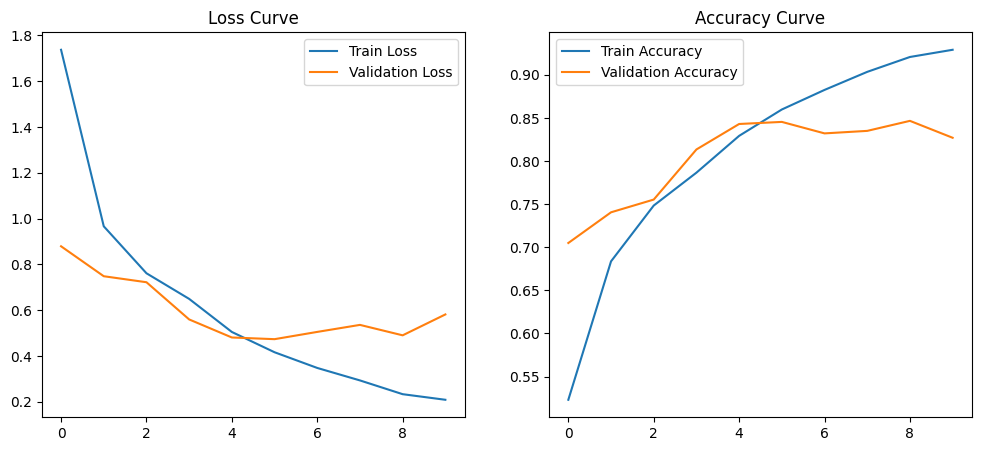


Classification Report:
                                              precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.82      0.60      0.69       181
                     Pepper__bell___healthy       0.93      0.96      0.94       288
                      Potato___Early_blight       0.87      0.93      0.90       194
                       Potato___Late_blight       0.70      0.79      0.74       194
                           Potato___healthy       0.66      0.61      0.63        31
                      Tomato_Bacterial_spot       0.84      0.92      0.88       441
                        Tomato_Early_blight       0.62      0.46      0.53       187
                         Tomato_Late_blight       0.78      0.80      0.79       384
                           Tomato_Leaf_Mold       0.91      0.70      0.79       210
                  Tomato_Septoria_leaf_spot       0.74      0.69      0.72       353
Tomato_Spider_mites_Two_spotted_spider_

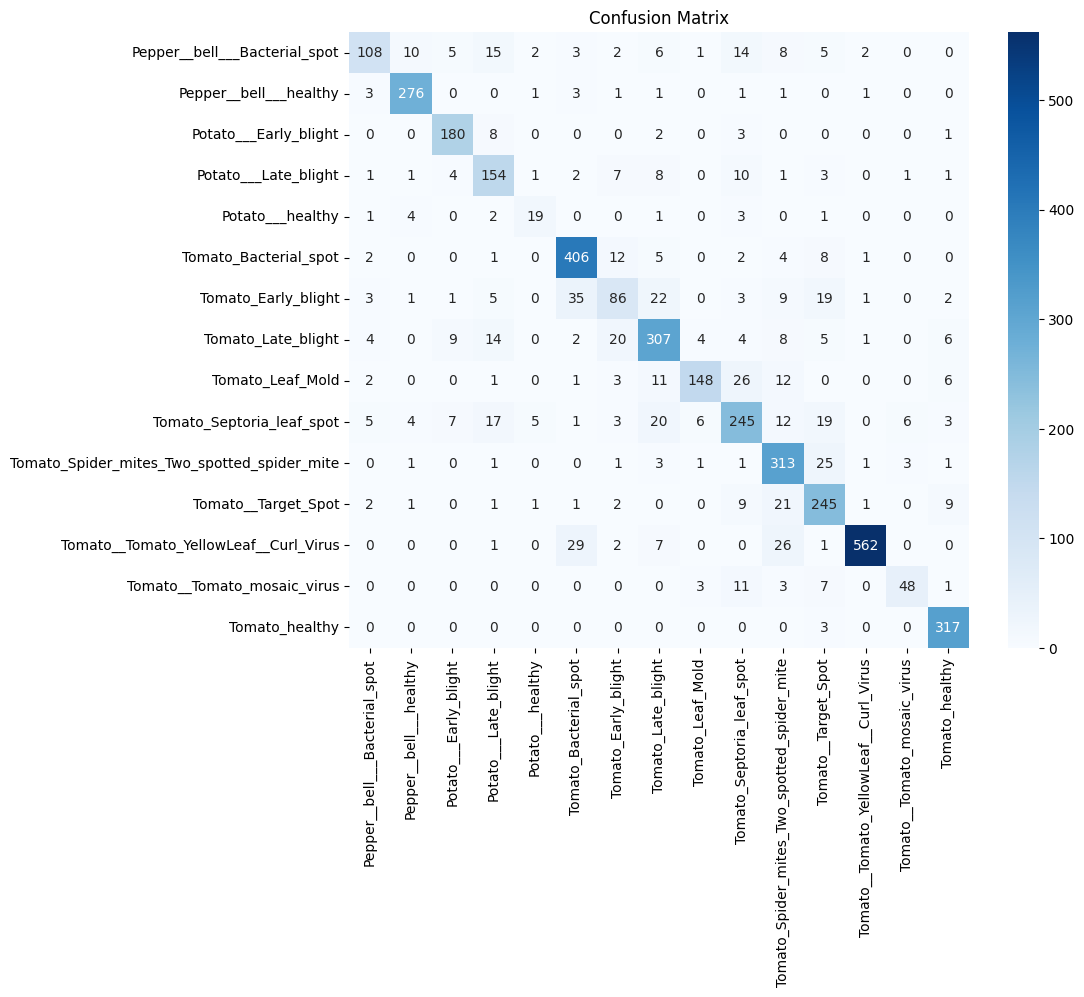


================ Summary ================
Training Accuracy: 92.91%
Validation Accuracy: 82.70%
Test Accuracy: 82.70%
Training Time: 0:22:36
Model Size: 784.32 MB


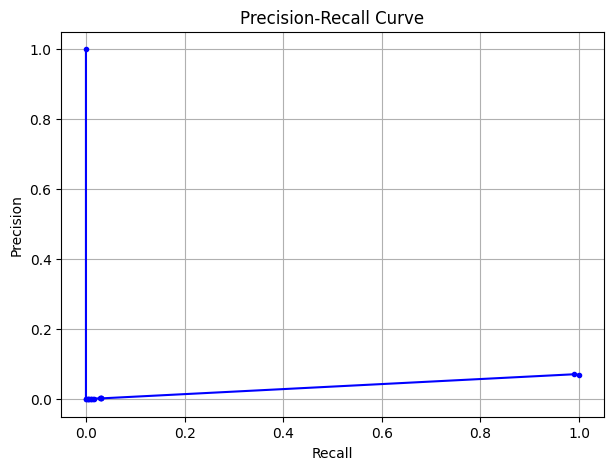

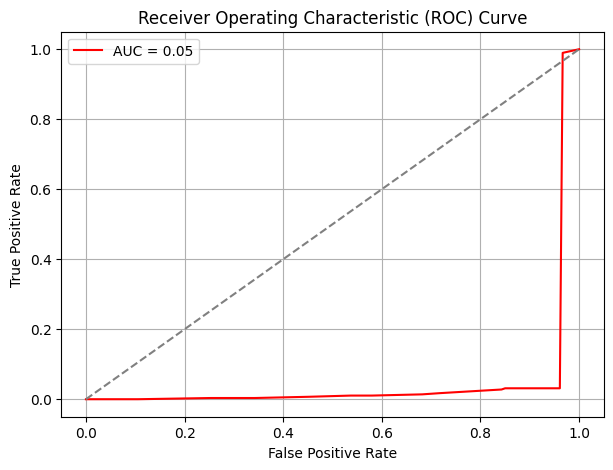


F1 Score (Macro Average): 0.7884


In [ ]:
# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Evaluation Metrics
all_labels, all_preds = [], []
model.eval()

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=dataset.classes))

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.show()

# Final Summary
correct, total = 0, 0
model.eval()

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

test_accuracy = 100 * correct / total
model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024 * 1024)  # in MB

print("\n================ Summary ================")
print(f"Training Accuracy: {train_accuracies[-1] * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracies[-1] * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Training Time: {training_time}")
print(f"Model Size: {model_size:.2f} MB")
print("========================================")

# Precision-Recall Analysis and ROC Curve
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score

# Convert to NumPy arrays
all_labels_np = np.array(all_labels)
all_preds_np = np.array(all_preds)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels_np, all_preds_np, pos_label=1)
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, marker='.', color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels_np, all_preds_np, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='r', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# F1 Score Calculation
f1 = f1_score(all_labels_np, all_preds_np, average='macro')
print(f"\nF1 Score (Macro Average): {f1:.4f}")